In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install skorch sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 185 kB 24.8 MB/s 
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=11aee60faa5875c24eeb8301d59875b05bb6c436a82e04b0dc1002ac27948689
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import os
import copy
import itertools
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
def set_seed(seed: int = 42) -> None:
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set as {seed}")

set_seed()

Random seed set as 42


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
folder_path = "./drive/MyDrive/ColabData/CV_lab2/"

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
image_datasets = {x: torchvision.datasets.CIFAR10(
    root=folder_path + "TrainingData",
    train=x == 'train',
    download=True,
    transform=transform
) for x in ['train', 'test']}

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_set_size = int(len(image_datasets['train']) * 0.8)
valid_set_size = len(image_datasets['train']) - train_set_size

image_datasets['train'], image_datasets['val'] = torch.utils.data.random_split(image_datasets['train'], [train_set_size, valid_set_size])

In [ ]:
def create_dataloaders(batch_size=64):
    return {x: torch.utils.data.DataLoader(
        image_datasets[x], 
        batch_size=batch_size, 
    ) for x in ['train', 'val', 'test']}

In [ ]:
dataloaders = create_dataloaders()

In [ ]:
dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val', 'test']}
dataset_sizes

{'train': 40000, 'val': 10000, 'test': 10000}

In [ ]:
class_names = dataloaders['test'].dataset.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

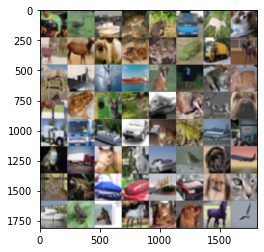

In [ ]:
def imshow(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)


inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out)

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, fully_connected_out, num_classes=10):
        super(AlexNet, self).__init__()

        self.fully_connected_out = fully_connected_out
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, fully_connected_out),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(fully_connected_out, fully_connected_out),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(fully_connected_out, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [ ]:
criterion = nn.CrossEntropyLoss()

net = NeuralNetClassifier(
        module=AlexNet, max_epochs=10,
        optimizer=torch.optim.SGD,
        criterion=criterion,
        lr=0.001, verbose=1
    )

params = {
    'lr': [0.001, 0.01, 0.005],
    'max_epochs': [5, 10, 15],
    'module__fully_connected_out': [4096, 2048, 6144],
}

gs = GridSearchCV(
        net, params, refit=False, scoring='accuracy', verbose=1, cv=2
    )

counter = 0
search_batches = 2

for i, (inputs, labels) in enumerate(dataloaders['train']):
    counter += 1
    # inputs = inputs.to(device)
    # labels = labels.to(device)
    outputs = gs.fit(inputs, labels)

    if counter == search_batches:
        break

Fitting 2 folds for each of 27 candidates, totalling 54 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3681       0.0000        2.3050  4.9187
      2        2.2411       0.0000        2.3052  2.6157
      3        2.2749       0.0000        2.3056  2.5767
      4        2.2905       0.0000        2.3060  2.6188
      5        2.2276       0.0000        2.3062  2.5970


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3972       0.0000        2.3058  2.4550
      2        2.3087       0.0000        2.3070  2.5888
      3        2.3225       0.0000        2.3077  2.5693
      4        2.2657       0.0000        2.3087  2.5441
      5        2.2782       0.0000        2.3100  2.5203


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.4331       0.1429        2.3016  2.3544
      2        2.3711       0.1429        2.3016  2.3177
      3        2.3132       0.2857        2.3014  2.3376
      4        2.2999       0.1429        2.3014  2.3539
      5        2.2220       0.0000        2.3016  2.3675


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3229       0.0000        2.3054  2.3224
      2        2.2368       0.0000        2.3052  2.3798
      3        2.2066       0.0000        2.3050  2.3495
      4        2.2175       0.0000        2.3052  2.3917
      5        2.2465       0.0000        2.3055  4.6738


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3464       0.2857        2.3029  2.8048
      2        2.2869       0.1429        2.3031  2.8746
      3        2.3184       0.1429        2.3029  4.1425
      4        2.2151       0.1429        2.3030  2.8228
      5        2.2614       0.1429        2.3032  2.8193


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3529       0.1429        2.3013  2.6788
      2        2.3026       0.1429        2.3020  2.8422
      3        2.2539       0.1429        2.3029  2.8321
      4        2.2465       0.1429        2.3037  2.8354
      5        2.1680       0.1429        2.3047  2.8261


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3344       0.1429        2.3015  2.5051
      2        2.2822       0.1429        2.3015  2.6395
      3        2.3091       0.1429        2.3018  2.5352
      4        2.2515       0.1429        2.3019  2.5276
      5        2.2060       0.1429        2.3021  2.5176
      6        2.2254       0.1429        2.3023  2.5451
      7        2.1900       0.1429        2.3027  2.6210
      8        2.1324       0.1429        2.3033  2.5808
      9        2.1917       0.1429        2.3040  2.5847
     10        2.1827       0.0000        2.3048  3.7511


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.2943       0.0000        2.3043  2.6021
      2        2.3003       0.0000        2.3046  2.6108
      3        2.2603       0.0000        2.3050  2.6385
      4        2.2425       0.0000        2.3058  2.5964
      5        2.1995       0.0000        2.3067  2.6195
      6        2.2220       0.0000        2.3079  2.6171
      7        2.2056       0.0000        2.3091  4.8395
      8        2.1598       0.0000        2.3104  3.7234
      9        2.1694       0.0000        2.3119  2.5915
     10        2.1298       0.0000        2.3137  2.6624


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3174       0.1429        2.3031  2.3901
      2        2.3153       0.1429        2.3031  2.3368
      3        2.2597       0.1429        2.3032  2.3176
      4        2.2276       0.1429        2.3030  2.2940
      5        2.2804       0.1429        2.3030  2.3686
      6        2.2004       0.1429        2.3031  2.3445
      7        2.2176       0.1429        2.3032  2.3867
      8        2.1749       0.1429        2.3032  2.3858
      9        2.2053       0.1429        2.3033  2.3748
     10        2.2367       0.1429        2.3035  2.3622


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3306       0.0000        2.3042  2.3360
      2        2.2944       0.0000        2.3039  2.3727
      3        2.3038       0.0000        2.3040  2.3710
      4        2.2944       0.0000        2.3044  2.3245
      5        2.3448       0.1429        2.3047  2.3174
      6        2.1888       0.1429        2.3051  2.6030
      7        2.2279       0.1429        2.3057  4.3039
      8        2.1890       0.1429        2.3064  3.3895
      9        2.2350       0.1429        2.3072  2.3855
     10        2.1772       0.1429        2.3085  2.3443


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3593       0.0000        2.3029  2.6433
      2        2.3804       0.0000        2.3033  2.7947
      3        2.2266       0.0000        2.3032  2.8107
      4        2.2954       0.0000        2.3031  2.8173
      5        2.3046       0.0000        2.3033  2.8103
      6        2.1927       0.0000        2.3039  2.8175
      7        2.2055       0.0000        2.3044  2.7836
      8        2.1372       0.0000        2.3048  2.7304
      9        2.1512       0.0000        2.3052  2.7648
     10        2.1352       0.0000        2.3056  2.8132


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3485       0.1429        2.3041  2.6725
      2        2.2945       0.0000        2.3045  2.7988
      3        2.2736       0.0000        2.3049  2.7313
      4        2.2873       0.0000        2.3056  2.8677
      5        2.1584       0.0000        2.3063  2.8440
      6        2.2199       0.0000        2.3071  2.8576
      7        2.1370       0.0000        2.3080  2.7938
      8        2.1162       0.0000        2.3091  2.8387
      9        2.1574       0.0000        2.3105  2.8399
     10        2.1223       0.0000        2.3119  2.7519


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3281       0.0000        2.3046  2.5610
      2        2.3137       0.0000        2.3046  2.4945
      3        2.3132       0.0000        2.3052  2.5333
      4        2.3042       0.0000        2.3057  2.4916
      5        2.2634       0.0000        2.3062  2.5631
      6        2.2076       0.0000        2.3070  2.5600
      7        2.1594       0.0000        2.3078  2.6004
      8        2.1920       0.0000        2.3087  2.5752
      9        2.1518       0.0000        2.3097  2.5313
     10        2.1520       0.0000        2.3108  2.5343
     11        2.1689       0.0000        2.3119  2.5597
     12        2.1199       0.0000        2.3131  2.5287
     13        2.1778       0.0000        2.3143  2.5803
     14        2.1709       0.0000        2.3157  2.5769
     15        2.0974       0.0000        2.3171  2.5380


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.2940       0.1429        2.3048  2.5617
      2        2.2976       0.1429        2.3052  2.6351
      3        2.3176       0.1429        2.3056  2.5859
      4        2.3343       0.1429        2.3065  2.5585
      5        2.2564       0.1429        2.3075  2.5593
      6        2.2739       0.1429        2.3086  2.5351
      7        2.2765       0.0000        2.3100  2.5211
      8        2.2351       0.0000        2.3116  2.5343
      9        2.1247       0.0000        2.3134  2.6049
     10        2.1152       0.0000        2.3154  2.5727
     11        2.1649       0.0000        2.3174  2.6105
     12        2.1751       0.0000        2.3202  2.6181
     13        2.0893       0.0000        2.3235  2.6085
     14        2.1049       0.0000        2.3264  2.6050
     15        2.0462       0.0000        2.3299  2.5483


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3515       0.1429        2.3024  2.3534
      2        2.2652       0.1429        2.3022  2.3718
      3        2.2687       0.1429        2.3026  2.3903
      4        2.2625       0.1429        2.3035  2.3899
      5        2.2551       0.1429        2.3041  2.4056
      6        2.3196       0.1429        2.3045  2.4575
      7        2.1844       0.1429        2.3049  2.3762
      8        2.2394       0.1429        2.3056  2.3781
      9        2.1926       0.0000        2.3063  2.3975
     10        2.1759       0.0000        2.3071  2.4401
     11        2.1410       0.0000        2.3081  2.3835
     12        2.1302       0.0000        2.3091  2.3969
     13        2.0878       0.0000        2.3099  2.3427
     14        2.1181       0.0000        2.3112  2.4100
     15        2.0640       0.0000        2.3123  2.3944


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3525       0.0000        2.3046  2.3026
      2        2.2831       0.0000        2.3047  2.3962
      3        2.2941       0.0000        2.3048  2.3633
      4        2.2895       0.0000        2.3051  2.3605
      5        2.2538       0.0000        2.3056  2.3235
      6        2.2259       0.0000        2.3060  2.3260
      7        2.2628       0.0000        2.3067  2.3450
      8        2.1578       0.0000        2.3075  2.4959
      9        2.1364       0.0000        2.3086  2.3091
     10        2.1506       0.0000        2.3097  2.3442
     11        2.1584       0.1429        2.3109  2.3774
     12        2.1302       0.1429        2.3126  2.4266
     13        2.0379       0.1429        2.3145  2.4015
     14        2.0795       0.1429        2.3162  2.3420
     15        2.1737       0.1429        2.3185  2.4307


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3091       0.1429        2.3043  2.6907
      2        2.2748       0.1429        2.3045  2.9040
      3        2.2482       0.1429        2.3051  2.8802
      4        2.1939       0.1429        2.3057  2.9417
      5        2.2175       0.1429        2.3063  2.8279
      6        2.1501       0.0000        2.3069  2.8347
      7        2.1750       0.0000        2.3076  2.7915
      8        2.1398       0.0000        2.3084  2.8138
      9        2.0917       0.0000        2.3094  2.7706
     10        2.1447       0.0000        2.3105  4.9261
     11        2.0569       0.0000        2.3115  3.8056
     12        2.1278       0.0000        2.3125  2.7460
     13        2.0214       0.0000        2.3134  2.7816
     14        2.0299       0.0000        2.3145  2.8426
     15        2.0647       0.0000        2.3154  2.7847


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3339       0.1429        2.3037  2.7315
      2        2.2947       0.1429        2.3040  2.8362
      3        2.2831       0.0000        2.3048  2.8834
      4        2.1918       0.0000        2.3057  2.9012
      5        2.2454       0.0000        2.3067  2.8522
      6        2.2446       0.0000        2.3081  2.8253
      7        2.1594       0.0000        2.3097  2.8426
      8        2.1675       0.0000        2.3114  2.8601
      9        2.1990       0.0000        2.3134  2.8718
     10        2.1128       0.0000        2.3155  2.8629
     11        2.0732       0.0000        2.3179  2.8664
     12        2.0994       0.0000        2.3206  4.8783
     13        2.0775       0.0000        2.3233  4.0370
     14        2.0943       0.1429        2.3261  2.7881
     15        2.0420       0.1429        2.3293  2.8659


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3704       0.0000        2.3046  2.5171
      2        2.1418       0.0000        2.3052  2.5765
      3        2.0075       0.0000        2.3059  2.6181
      4        2.0313       0.0000        2.3067  2.5941
      5        1.9601       0.0000        2.3072  2.5852


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3491       0.0000        2.3074  2.4341
      2        2.1483       0.0000        2.3087  2.5157
      3        2.0787       0.0000        2.3105  2.5655
      4        1.9297       0.0000        2.3120  2.5519
      5        1.9484       0.0000        2.3145  2.5494


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3332       0.0000        2.3047  2.3410
      2        2.2151       0.0000        2.3055  2.3597
      3        2.1151       0.0000        2.3061  2.3465
      4        2.0818       0.1429        2.3065  2.2907
      5        1.9488       0.1429        2.3072  2.4276


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3103       0.1429        2.2994  2.3157
      2        2.2347       0.1429        2.3005  2.3482
      3        2.1485       0.1429        2.3014  2.3047
      4        2.0029       0.1429        2.3020  2.3508
      5        1.8785       0.1429        2.3031  2.3251


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3731       0.1429        2.3046  2.6665
      2        2.1540       0.1429        2.3051  2.8050
      3        2.0520       0.1429        2.3056  2.7901
      4        1.9916       0.1429        2.3062  2.7859
      5        1.9002       0.0000        2.3073  2.8546


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3703       0.1429        2.3053  2.6326
      2        2.1255       0.1429        2.3062  2.7416
      3        2.0264       0.0000        2.3073  2.7775
      4        1.9302       0.1429        2.3092  2.7630
      5        1.9130       0.1429        2.3111  2.8789


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3292       0.1429        2.3034  2.4599
      2        2.1357       0.1429        2.3043  2.5239
      3        2.0634       0.1429        2.3048  2.5049
      4        2.0044       0.1429        2.3061  2.5444
      5        1.9781       0.1429        2.3061  2.5254
      6        1.8423       0.1429        2.3063  2.5826
      7        1.7686       0.1429        2.3063  2.5330
      8        1.6805       0.1429        2.3064  2.4993
      9        1.6381       0.1429        2.3051  2.4992
     10        1.5172       0.1429        2.3045  2.4800


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3789       0.1429        2.3023  2.5328
      2        2.1257       0.1429        2.3037  2.5090
      3        2.0484       0.1429        2.3050  2.5175
      4        1.9192       0.1429        2.3063  2.5131
      5        1.7944       0.1429        2.3091  2.5091
      6        1.8618       0.1429        2.3119  2.4857
      7        1.6938       0.1429        2.3131  2.5007
      8        1.6771       0.1429        2.3155  2.6153
      9        1.5965       0.1429        2.3198  2.5176
     10        1.4938       0.1429        2.3250  2.5232


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.2934       0.0000        2.3055  2.3542
      2        2.1691       0.1429        2.3060  2.3682
      3        2.1027       0.0000        2.3061  2.3470
      4        2.0738       0.1429        2.3066  2.3042
      5        1.9894       0.1429        2.3071  2.3140
      6        1.8700       0.1429        2.3071  2.2926
      7        1.8268       0.1429        2.3077  2.3268
      8        1.7920       0.0000        2.3090  2.3563
      9        1.6681       0.0000        2.3076  2.3070
     10        1.5566       0.0000        2.3066  2.4567


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3457       0.1429        2.3034  2.2657
      2        2.1510       0.1429        2.3044  2.2892
      3        2.0658       0.1429        2.3058  2.3363
      4        2.0453       0.0000        2.3074  2.3075
      5        1.8918       0.0000        2.3106  2.3843
      6        1.9062       0.0000        2.3120  2.3101
      7        1.7795       0.0000        2.3164  2.2820
      8        1.7620       0.0000        2.3200  2.3056
      9        1.7577       0.0000        2.3228  2.3239
     10        1.6311       0.0000        2.3269  2.3056


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3659       0.1429        2.3029  2.6171
      2        2.1587       0.1429        2.3033  2.8553
      3        2.0930       0.1429        2.3037  2.6727
      4        2.0118       0.0000        2.3048  2.6839
      5        1.9176       0.1429        2.3045  2.7393
      6        1.8622       0.1429        2.3041  2.8160
      7        1.7910       0.1429        2.3043  2.7938
      8        1.7514       0.1429        2.3023  2.7972
      9        1.6401       0.1429        2.3029  2.7880
     10        1.5455       0.1429        2.3026  2.8112


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.2874       0.1429        2.3052  2.7137
      2        2.0919       0.1429        2.3059  2.8498
      3        2.0174       0.1429        2.3074  2.8490
      4        1.9130       0.0000        2.3097  2.8312
      5        1.8442       0.1429        2.3112  4.3478
      6        1.7667       0.0000        2.3140  4.5051
      7        1.6976       0.0000        2.3156  2.7828
      8        1.5905       0.0000        2.3184  2.7927
      9        1.5659       0.0000        2.3218  2.7883
     10        1.3955       0.1429        2.3215  2.8124


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3025       0.0000        2.3049  2.5675
      2        2.1812       0.0000        2.3053  2.6147
      3        2.0973       0.0000        2.3061  2.5450
      4        1.9274       0.0000        2.3064  2.5529
      5        1.9221       0.0000        2.3061  2.5631
      6        1.8796       0.0000        2.3060  2.6162
      7        1.7965       0.0000        2.3037  2.6436
      8        1.6856       0.0000        2.3026  2.6312
      9        1.5939       0.0000        2.3019  2.6551
     10        1.4921       0.0000        2.2969  2.5952
     11        1.5320       0.1429        2.2960  2.6290
     12        1.4280       0.1429        2.2922  2.6301
     13        1.3658       0.1429        2.2883  2.6385
     14        1.2355       0.1429        2.2813  2.5696
     15        1.1970       0.1429        2.2797  2.5433


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3540       0.0000        2.3045  4.5578
      2        2.1643       0.1429        2.3070  3.7006
      3        2.1128       0.1429        2.3097  2.5737
      4        1.9943       0.1429        2.3124  2.5616
      5        1.9117       0.1429        2.3150  2.5205
      6        1.9254       0.1429        2.3176  2.5759
      7        1.7597       0.1429        2.3212  2.5853
      8        1.7407       0.0000        2.3248  2.6075
      9        1.6040       0.0000        2.3292  2.5935
     10        1.5681       0.0000        2.3342  2.5883
     11        1.5077       0.0000        2.3397  2.5450
     12        1.4853       0.0000        2.3462  2.5509
     13        1.2865       0.0000        2.3493  2.6338
     14        1.3082       0.0000        2.3544  2.5549
     15        1.2549       0.0000        2.3689  2.5776


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.4224       0.1429        2.2989  2.3722
      2        2.2354       0.1429        2.2996  2.3581
      3        2.0922       0.1429        2.3001  2.3434
      4        2.0173       0.1429        2.3003  2.3550
      5        1.9012       0.0000        2.3022  2.4786
      6        1.8789       0.1429        2.3030  2.4191
      7        1.7539       0.1429        2.3047  2.4107
      8        1.7286       0.0000        2.3044  2.3187
      9        1.6227       0.0000        2.3071  2.3913
     10        1.6317       0.0000        2.3067  2.3636
     11        1.4761       0.0000        2.3071  2.3517
     12        1.3981       0.0000        2.3066  2.3447
     13        1.3285       0.0000        2.3071  2.3175
     14        1.2988       0.0000        2.3082  2.3366
     15        1.2503       0.0000        2.3039  2.4000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3058       0.1429        2.3028  2.3081
      2        2.1033       0.1429        2.3035  2.3840
      3        2.0529       0.1429        2.3055  2.3169
      4        1.9322       0.1429        2.3071  2.3197
      5        1.9133       0.1429        2.3089  2.3087
      6        1.8207       0.1429        2.3114  2.3351
      7        1.7487       0.0000        2.3138  2.3363
      8        1.7224       0.0000        2.3163  2.3515
      9        1.5630       0.1429        2.3201  2.3443
     10        1.5852       0.1429        2.3213  2.3508
     11        1.4805       0.1429        2.3279  2.3046
     12        1.4235       0.1429        2.3305  2.3514
     13        1.3477       0.1429        2.3396  2.3070
     14        1.2796       0.1429        2.3423  2.2910
     15        1.2619       0.1429        2.3499  2.3210


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3933       0.0000        2.3039  2.6349
      2        2.0857       0.0000        2.3047  2.7441
      3        2.0268       0.0000        2.3060  2.7712
      4        2.0267       0.0000        2.3065  2.7480
      5        1.8868       0.0000        2.3083  2.7743
      6        1.8160       0.0000        2.3093  2.7599
      7        1.7484       0.0000        2.3081  2.7336
      8        1.6651       0.0000        2.3095  2.7039
      9        1.6327       0.0000        2.3101  2.7131
     10        1.5747       0.0000        2.3089  2.7306
     11        1.4177       0.0000        2.3105  2.8409
     12        1.3944       0.1429        2.3072  2.7420
     13        1.3664       0.0000        2.3072  2.7751
     14        1.2252       0.0000        2.3053  2.7940
     15        1.2209       0.1429        2.3013  2.7880


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3128       0.2857        2.3034  2.6328
      2        2.1064       0.0000        2.3048  2.7647
      3        2.1064       0.0000        2.3078  2.7417
      4        1.9212       0.0000        2.3094  2.7847
      5        1.9299       0.0000        2.3122  2.7601
      6        1.8375       0.0000        2.3133  2.8007
      7        1.7203       0.0000        2.3166  2.7282
      8        1.5638       0.0000        2.3187  2.7255
      9        1.5329       0.0000        2.3231  2.8073
     10        1.4911       0.0000        2.3240  2.7500
     11        1.4168       0.1429        2.3303  2.7392
     12        1.3422       0.0000        2.3375  2.7910
     13        1.3061       0.1429        2.3423  2.7197
     14        1.1693       0.1429        2.3451  2.7502
     15        1.0631       0.1429        2.3562  2.7808


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.4455       0.1429        2.3053  2.4960
      2        2.1907       0.0000        2.3064  2.6291
      3        2.1840       0.0000        2.3072  2.4706
      4        2.1471       0.0000        2.3082  2.4756
      5        2.0744       0.0000        2.3092  2.5016


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.2845       0.2857        2.3032  4.2950
      2        2.2531       0.1429        2.3048  3.8961
      3        2.1384       0.1429        2.3069  2.4882
      4        2.1160       0.1429        2.3085  2.5135
      5        2.0575       0.1429        2.3103  2.5109


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3036       0.1429        2.3046  2.2796
      2        2.3210       0.0000        2.3047  2.4334
      3        2.2000       0.0000        2.3047  2.3560
      4        2.1539       0.0000        2.3049  2.2487
      5        2.1244       0.0000        2.3052  2.3391


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.2532       0.1429        2.3043  2.2266
      2        2.1677       0.1429        2.3053  2.3063
      3        2.1365       0.1429        2.3070  2.2564
      4        2.1181       0.1429        2.3086  2.2980
      5        2.0318       0.1429        2.3106  2.3007


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3156       0.1429        2.3041  2.6879
      2        2.1494       0.1429        2.3047  2.7646
      3        2.0889       0.1429        2.3054  2.6892
      4        2.0425       0.1429        2.3061  2.8527
      5        2.0794       0.1429        2.3072  2.7141


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3229       0.0000        2.3064  2.6173
      2        2.1304       0.0000        2.3084  2.8101
      3        2.1104       0.0000        2.3104  2.7384
      4        2.0670       0.0000        2.3126  2.7032
      5        1.9646       0.0000        2.3139  2.7835


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3380       0.1429        2.3025  2.4899
      2        2.2583       0.1429        2.3028  2.5791
      3        2.1797       0.1429        2.3040  2.5815
      4        2.1135       0.1429        2.3051  2.5939
      5        2.1130       0.1429        2.3060  2.5564
      6        1.9964       0.0000        2.3073  2.5587
      7        2.0206       0.0000        2.3081  3.5971
      8        1.8426       0.0000        2.3092  4.6854
      9        1.8283       0.0000        2.3099  2.5778
     10        1.7535       0.0000        2.3096  2.4407


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3726       0.0000        2.3056  2.3984
      2        2.1703       0.0000        2.3072  2.4897
      3        2.1134       0.0000        2.3088  2.5081
      4        2.0686       0.0000        2.3107  2.5303
      5        1.9677       0.0000        2.3123  2.5251
      6        1.9612       0.0000        2.3142  2.5118
      7        1.9648       0.0000        2.3160  2.5826
      8        1.9222       0.0000        2.3175  2.5398
      9        1.8024       0.0000        2.3200  2.5360
     10        1.7426       0.0000        2.3229  2.5591


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3310       0.0000        2.3029  2.3107
      2        2.3016       0.0000        2.3038  2.2893
      3        2.1881       0.0000        2.3045  2.2912
      4        2.1748       0.0000        2.3056  2.3497
      5        2.0913       0.0000        2.3069  2.3360
      6        2.0510       0.0000        2.3083  2.4021
      7        2.0350       0.0000        2.3092  2.3361
      8        1.9479       0.0000        2.3104  2.3437
      9        1.9357       0.0000        2.3114  2.2605
     10        1.8973       0.0000        2.3122  2.3003


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3977       0.1429        2.3039  2.2786
      2        2.2587       0.1429        2.3047  2.2870
      3        2.1597       0.1429        2.3061  2.2519
      4        2.1067       0.1429        2.3077  2.2928
      5        2.0771       0.1429        2.3091  2.2753
      6        2.0463       0.1429        2.3112  2.3228
      7        1.9038       0.0000        2.3126  2.2405
      8        1.8935       0.0000        2.3148  2.2702
      9        1.9268       0.0000        2.3185  2.3783
     10        1.8572       0.0000        2.3210  2.2985


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.2897       0.0000        2.3038  2.6167
      2        2.1447       0.0000        2.3045  2.7382
      3        2.1550       0.0000        2.3049  2.7599
      4        1.9965       0.0000        2.3057  2.7223
      5        2.0044       0.0000        2.3061  2.7876
      6        2.0009       0.0000        2.3061  2.6984
      7        1.9154       0.0000        2.3064  2.7222
      8        1.9026       0.0000        2.3061  2.7338
      9        1.8071       0.0000        2.3071  2.7689
     10        1.8375       0.0000        2.3068  2.8262


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3540       0.1429        2.3014  2.6956
      2        2.1406       0.1429        2.3031  2.7134
      3        2.0940       0.1429        2.3048  2.7900
      4        2.0386       0.1429        2.3071  2.7900
      5        1.9684       0.1429        2.3088  2.7582
      6        1.8858       0.1429        2.3113  2.6835
      7        1.8313       0.1429        2.3143  2.6889
      8        1.8447       0.1429        2.3162  2.7728
      9        1.8148       0.1429        2.3193  2.7503
     10        1.7142       0.1429        2.3228  2.8363


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3791       0.1429        2.3006  2.4444
      2        2.2355       0.1429        2.3014  2.4964
      3        2.1885       0.0000        2.3030  2.5205
      4        2.0967       0.0000        2.3041  2.4986
      5        2.0602       0.0000        2.3054  2.4767
      6        1.9956       0.0000        2.3060  2.4409
      7        2.0165       0.0000        2.3073  2.4965
      8        1.9356       0.1429        2.3081  2.4876
      9        1.9616       0.0000        2.3093  2.4767
     10        1.8280       0.0000        2.3102  2.5093
     11        1.7635       0.0000        2.3116  2.4708
     12        1.7845       0.0000        2.3130  2.5191
     13        1.6570       0.0000        2.3138  2.5455
     14        1.6361       0.0000        2.3147  2.4598
     15        1.6290       0.0000        2.3145  2.4939


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3057       0.1429        2.3035  2.3891
      2        2.1810       0.1429        2.3049  2.4961
      3        2.1123       0.1429        2.3065  2.5233
      4        2.0699       0.0000        2.3081  2.5444
      5        2.0203       0.0000        2.3098  2.5291
      6        1.9444       0.0000        2.3117  2.5536
      7        1.9362       0.0000        2.3139  2.5106
      8        1.8468       0.0000        2.3158  2.5115
      9        1.7773       0.0000        2.3176  4.3747
     10        1.7836       0.0000        2.3205  3.8792
     11        1.7214       0.0000        2.3247  2.5172
     12        1.7526       0.0000        2.3289  2.4760
     13        1.6689       0.0000        2.3315  2.4613
     14        1.6304       0.0000        2.3357  2.4640
     15        1.5354       0.0000        2.3401  2.4872


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3173       0.0000        2.2998  2.2244
      2        2.2889       0.1429        2.3010  2.2841
      3        2.2267       0.1429        2.3016  2.2523
      4        2.1490       0.1429        2.3027  2.3308
      5        2.0326       0.1429        2.3042  2.3638
      6        1.9876       0.1429        2.3058  2.2955
      7        2.0273       0.1429        2.3073  2.3081
      8        1.9837       0.1429        2.3083  2.3347
      9        1.9201       0.1429        2.3096  2.2729
     10        1.9435       0.1429        2.3107  2.2896
     11        1.8740       0.1429        2.3124  2.2796
     12        1.7774       0.1429        2.3126  2.2423
     13        1.8145       0.1429        2.3142  2.2960
     14        1.6995       0.1429        2.3149  2.3176
     15        1.6950       0.1429        2.3164  2.3031


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.2826       0.0000        2.3052  2.2477
      2        2.2416       0.0000        2.3065  2.3457
      3        2.1715       0.0000        2.3085  2.2723
      4        2.1205       0.0000        2.3104  2.3014
      5        2.0945       0.0000        2.3127  2.3164
      6        2.0286       0.0000        2.3147  2.2958
      7        2.0121       0.0000        2.3174  2.3388
      8        1.9335       0.0000        2.3193  2.3350
      9        1.8266       0.0000        2.3234  2.3088
     10        1.8397       0.0000        2.3265  2.2914
     11        1.8035       0.0000        2.3303  2.3467
     12        1.8305       0.0000        2.3335  2.3158
     13        1.7598       0.0000        2.3389  2.3079
     14        1.8071       0.0000        2.3432  2.2778
     15        1.6848       0.0000        2.3495  2.3994


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.2738       0.0000        2.3025  2.6650
      2        2.2159       0.0000        2.3026  2.8842
      3        2.1031       0.0000        2.3032  5.0146
      4        2.0800       0.0000        2.3041  3.3911
      5        2.0593       0.0000        2.3044  2.6814
      6        1.9085       0.0000        2.3046  2.7357
      7        1.9322       0.0000        2.3054  2.7486
      8        1.9052       0.0000        2.3056  2.7153
      9        1.8208       0.0000        2.3053  2.7140
     10        1.7445       0.0000        2.3057  2.8149
     11        1.6919       0.0000        2.3055  2.7987
     12        1.6781       0.0000        2.3063  2.7353
     13        1.6747       0.0000        2.3064  2.7509
     14        1.6327       0.0000        2.3065  2.7682
     15        1.5315       0.0000        2.3059  2.7482


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3176       0.1429        2.3040  2.6324
      2        2.1159       0.1429        2.3062  2.8061
      3        2.2181       0.0000        2.3078  2.7678
      4        2.0266       0.0000        2.3105  2.7119
      5        2.0383       0.0000        2.3124  2.7519
      6        1.9478       0.0000        2.3142  2.7624
      7        1.9293       0.0000        2.3167  2.6726
      8        1.8674       0.0000        2.3190  2.7120
      9        1.8493       0.0000        2.3228  2.7790
     10        1.8129       0.0000        2.3261  2.7502
     11        1.7454       0.1429        2.3303  2.7987
     12        1.6955       0.1429        2.3341  2.7605
     13        1.6919       0.1429        2.3372  2.7517
     14        1.6540       0.1429        2.3423  2.7898
     15        1.5694       0.1429        2.3493  2.7595
Fitting 2 folds for each of 27 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3463       0.1429        2.3000  2.5338
      2        2.2991       0.1429        2.2991  2.5249
      3        2.2823       0.1429        2.2986  2.5358
      4        2.3126       0.1429        2.2983  2.5437
      5        2.1687       0.1429        2.2981  2.4920


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3976       0.1429        2.3029  2.4096
      2        2.2577       0.1429        2.3031  2.4661
      3        2.2759       0.1429        2.3029  2.5171
      4        2.2383       0.1429        2.3030  2.5081
      5        2.2118       0.1429        2.3031  2.4606


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3935       0.1429        2.3012  2.2478
      2        2.2838       0.1429        2.3010  2.3955
      3        2.1657       0.1429        2.3009  2.3443
      4        2.3078       0.1429        2.3005  2.2991
      5        2.1839       0.1429        2.3000  2.2921


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3461       0.0000        2.3085  2.2829
      2        2.3386       0.0000        2.3082  2.3530
      3        2.3110       0.0000        2.3083  2.3910
      4        2.3055       0.0000        2.3080  2.3469
      5        2.2351       0.0000        2.3077  2.3598


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3403       0.1429        2.3037  2.7370
      2        2.2044       0.1429        2.3031  2.7814
      3        2.1939       0.1429        2.3028  2.7982
      4        2.2557       0.1429        2.3022  2.7694
      5        2.1786       0.1429        2.3016  2.7806


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3445       0.1429        2.3031  2.6955
      2        2.2600       0.1429        2.3023  2.7686
      3        2.2803       0.1429        2.3015  2.7413
      4        2.1879       0.1429        2.3006  2.7720
      5        2.1833       0.1429        2.2996  2.7144


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3483       0.0000        2.3061  2.4906
      2        2.2996       0.0000        2.3050  2.5990
      3        2.2548       0.1429        2.3039  2.5914
      4        2.2334       0.1429        2.3029  2.5639
      5        2.1957       0.1429        2.3020  2.5444
      6        2.1818       0.1429        2.3010  2.6134
      7        2.2317       0.1429        2.3001  2.5476
      8        2.2070       0.1429        2.2990  2.4974
      9        2.2275       0.1429        2.2980  2.4881
     10        2.1425       0.1429        2.2968  2.5597


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3741       0.1429        2.3042  2.5786
      2        2.3305       0.1429        2.3039  2.5499
      3        2.2961       0.1429        2.3040  2.4679
      4        2.2877       0.1429        2.3037  2.5629
      5        2.2562       0.1429        2.3036  2.6419
      6        2.2064       0.1429        2.3036  4.3762
      7        2.1404       0.1429        2.3037  3.9001
      8        2.1476       0.1429        2.3038  2.5452
      9        2.1549       0.1429        2.3037  2.4825
     10        2.1456       0.1429        2.3037  2.5576


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3624       0.2857        2.3034  2.2204
      2        2.2794       0.2857        2.3035  2.2975
      3        2.3680       0.1429        2.3034  2.3002
      4        2.2846       0.1429        2.3032  2.2715
      5        2.2644       0.1429        2.3031  2.2753
      6        2.2376       0.1429        2.3030  2.3740
      7        2.1998       0.1429        2.3030  2.2561
      8        2.2479       0.1429        2.3028  2.2390
      9        2.2423       0.1429        2.3025  2.2323
     10        2.1638       0.1429        2.3022  2.2611


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3672       0.0000        2.3040  2.2801
      2        2.3124       0.0000        2.3040  2.2604
      3        2.3407       0.0000        2.3041  2.2344
      4        2.2731       0.0000        2.3044  2.2483
      5        2.2736       0.1429        2.3045  2.2962
      6        2.3423       0.1429        2.3046  2.2586
      7        2.2530       0.1429        2.3046  2.2831
      8        2.2303       0.1429        2.3044  2.2983
      9        2.2369       0.1429        2.3040  2.4281
     10        2.2014       0.1429        2.3038  2.2595


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.2846       0.1429        2.3037  2.5649
      2        2.2312       0.1429        2.3036  2.7357
      3        2.3089       0.1429        2.3031  2.6905
      4        2.2111       0.1429        2.3024  2.7369
      5        2.2095       0.1429        2.3018  2.7472
      6        2.1931       0.1429        2.3012  2.7020
      7        2.1879       0.1429        2.3006  2.6949
      8        2.1415       0.1429        2.3001  2.7308
      9        2.1185       0.1429        2.2993  2.8067
     10        2.1477       0.0000        2.2985  2.8806


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3684       0.1429        2.3015  4.3904
      2        2.2990       0.1429        2.3011  2.7220
      3        2.3303       0.1429        2.3009  2.6942
      4        2.2326       0.1429        2.3006  2.7040
      5        2.2032       0.1429        2.3004  2.6914
      6        2.2279       0.2857        2.3003  2.7189
      7        2.1536       0.1429        2.3002  2.7107
      8        2.1498       0.1429        2.3001  2.7197
      9        2.0777       0.1429        2.2999  2.8054
     10        2.2045       0.1429        2.2999  2.6904


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3713       0.0000        2.3056  2.3857
      2        2.3086       0.0000        2.3058  2.4718
      3        2.2706       0.0000        2.3055  2.4057
      4        2.2569       0.0000        2.3051  2.5587
      5        2.2323       0.0000        2.3049  2.5112
      6        2.1754       0.0000        2.3048  2.4754
      7        2.2184       0.0000        2.3044  2.4139
      8        2.1667       0.0000        2.3039  2.4656
      9        2.1297       0.1429        2.3034  2.4720
     10        2.1240       0.1429        2.3028  2.4248
     11        2.0547       0.1429        2.3020  2.5279
     12        2.1159       0.1429        2.3010  2.4348
     13        2.0602       0.1429        2.3000  2.4638
     14        2.1410       0.1429        2.2983  2.4831
     15        2.0463       0.2857        2.2969  2.4244


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3538       0.1429        2.3002  2.4026
      2        2.3557       0.1429        2.3003  2.5232
      3        2.2802       0.1429        2.3004  2.4776
      4        2.2377       0.1429        2.3009  2.5140
      5        2.2033       0.1429        2.3013  2.4289
      6        2.2213       0.1429        2.3017  2.4451
      7        2.2198       0.1429        2.3022  2.5149
      8        2.1923       0.1429        2.3027  2.5621
      9        2.2068       0.1429        2.3032  2.4187
     10        2.1908       0.1429        2.3038  2.4125
     11        2.1881       0.1429        2.3042  2.4099
     12        2.1216       0.1429        2.3048  2.4214
     13        2.1050       0.1429        2.3051  2.4355
     14        2.0564       0.1429        2.3049  2.4366
     15        2.0511       0.1429        2.3049  2.5112


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3170       0.1429        2.2998  2.2609
      2        2.3509       0.1429        2.3004  2.2999
      3        2.2797       0.1429        2.3003  2.2681
      4        2.2228       0.1429        2.3002  2.2416
      5        2.2947       0.1429        2.3002  2.3663
      6        2.2843       0.1429        2.3001  2.2655
      7        2.2291       0.1429        2.2999  2.2533
      8        2.2085       0.1429        2.2997  2.2825
      9        2.1645       0.1429        2.2996  2.2562
     10        2.2434       0.2857        2.2995  2.2488
     11        2.1654       0.1429        2.2996  2.2737
     12        2.0656       0.1429        2.2995  2.2430
     13        2.1139       0.1429        2.2990  2.2165
     14        2.0825       0.1429        2.2986  2.2060
     15        2.0645       0.1429        2.2975  2.2323


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3109       0.0000        2.3085  2.2199
      2        2.4006       0.0000        2.3080  2.2647
      3        2.3635       0.0000        2.3076  2.3875
      4        2.2235       0.0000        2.3073  2.3016
      5        2.2802       0.0000        2.3070  2.2912
      6        2.2689       0.0000        2.3068  2.2998
      7        2.2379       0.0000        2.3064  2.2844
      8        2.1927       0.0000        2.3061  2.3269
      9        2.2105       0.0000        2.3058  2.3232
     10        2.1386       0.1429        2.3056  2.2471
     11        2.1489       0.1429        2.3048  2.2964
     12        2.2475       0.1429        2.3041  2.2914
     13        2.1313       0.1429        2.3033  2.3115
     14        2.1457       0.1429        2.3022  2.2694
     15        2.0908       0.1429        2.3009  2.2751


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3300       0.1429        2.3007  2.6356
      2        2.3274       0.1429        2.3012  2.7053
      3        2.2908       0.1429        2.3014  2.7359
      4        2.2217       0.1429        2.3012  2.7005
      5        2.1354       0.1429        2.3010  2.7305
      6        2.1449       0.1429        2.3007  2.6924
      7        2.1451       0.1429        2.3002  2.7327
      8        2.2101       0.1429        2.2998  2.6826
      9        2.1095       0.1429        2.2996  2.6835
     10        2.1343       0.1429        2.2993  2.7092
     11        2.0711       0.1429        2.2988  4.1323
     12        2.1198       0.1429        2.2979  4.4421
     13        2.0131       0.1429        2.2969  2.7125
     14        1.9969       0.1429        2.2956  2.6555
     15        2.0323       0.1429        2.2942  2.6877


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.2977       0.0000        2.3010  2.6140
      2        2.2580       0.0000        2.3010  2.7138
      3        2.2641       0.0000        2.3008  2.7217
      4        2.1735       0.0000        2.3004  2.7698
      5        2.1797       0.0000        2.2997  2.7591
      6        2.1919       0.1429        2.2991  2.7509
      7        2.1347       0.1429        2.2985  2.6980
      8        2.1237       0.1429        2.2980  2.6476
      9        2.1164       0.1429        2.2976  2.6843
     10        2.1093       0.1429        2.2971  2.6809
     11        2.0370       0.1429        2.2965  2.6673
     12        2.0443       0.1429        2.2959  2.6962
     13        2.0288       0.1429        2.2954  2.6759
     14        1.9715       0.1429        2.2950  2.6840
     15        2.0098       0.1429        2.2944  2.6541


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3475       0.0000        2.3030  2.4207
      2        2.1341       0.1429        2.3020  2.5033
      3        2.0812       0.1429        2.3014  2.4540
      4        1.9941       0.1429        2.3010  2.4276
      5        1.8579       0.1429        2.3000  2.4968


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3243       0.1429        2.3030  2.3806
      2        2.1720       0.1429        2.3031  2.4530
      3        2.0953       0.0000        2.3032  2.4528
      4        1.9787       0.0000        2.3038  2.4383
      5        1.9047       0.1429        2.3042  2.4770


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3636       0.1429        2.2987  2.2887
      2        2.1902       0.1429        2.2976  2.3125
      3        2.0792       0.1429        2.2969  3.7870
      4        1.9939       0.1429        2.2953  4.3493
      5        1.9296       0.1429        2.2945  2.2631


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3273       0.1429        2.3004  2.2945
      2        2.1898       0.1429        2.3000  2.2950
      3        2.1256       0.1429        2.2993  2.3163
      4        2.0500       0.1429        2.2990  2.2805
      5        1.9531       0.1429        2.2993  2.3015


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3782       0.1429        2.2993  2.6023
      2        2.1606       0.1429        2.2985  2.6822
      3        1.9866       0.1429        2.2980  2.6844
      4        1.9223       0.1429        2.2980  2.7492
      5        1.8272       0.1429        2.2971  2.6748


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3360       0.1429        2.3040  2.5777
      2        2.1668       0.1429        2.3042  2.6828
      3        2.0038       0.1429        2.3048  2.6939
      4        1.8929       0.1429        2.3049  2.7089
      5        1.8871       0.1429        2.3045  2.7166


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3652       0.1429        2.3017  2.4132
      2        2.1383       0.1429        2.3000  2.4496
      3        2.0552       0.1429        2.2997  2.4858
      4        1.9797       0.1429        2.2991  2.4648
      5        1.9290       0.1429        2.2981  2.5609
      6        1.8223       0.1429        2.2976  2.4367
      7        1.6947       0.1429        2.2970  2.4321
      8        1.7095       0.0000        2.2967  2.4487
      9        1.5924       0.1429        2.2956  2.4621
     10        1.5470       0.0000        2.2954  2.4282


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3078       0.1429        2.3047  2.3774
      2        2.1595       0.1429        2.3041  2.4424
      3        2.0183       0.1429        2.3035  2.4492
      4        1.9108       0.0000        2.3030  2.4232
      5        1.8690       0.1429        2.3029  2.4289
      6        1.7846       0.1429        2.3021  2.5020
      7        1.7364       0.1429        2.3021  2.4880
      8        1.6424       0.1429        2.3012  2.4921
      9        1.5442       0.1429        2.3007  2.4752
     10        1.5282       0.1429        2.3010  2.4890


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3002       0.1429        2.3014  2.2616
      2        2.2291       0.1429        2.3000  2.2754
      3        2.1100       0.1429        2.2993  2.2651
      4        2.0201       0.1429        2.2996  2.3014
      5        1.9724       0.1429        2.2996  2.3530
      6        1.9234       0.1429        2.2996  2.2427
      7        1.8586       0.1429        2.3010  2.2185
      8        1.7844       0.1429        2.3009  2.2605
      9        1.6535       0.1429        2.3014  2.3477
     10        1.5592       0.1429        2.3041  2.3297


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3352       0.1429        2.2987  2.2631
      2        2.2298       0.1429        2.2988  2.3144
      3        2.1396       0.1429        2.2988  2.2508
      4        2.0579       0.1429        2.2985  2.2143
      5        1.9693       0.1429        2.2985  2.2606
      6        1.8500       0.1429        2.2982  2.2812
      7        1.7725       0.1429        2.2975  2.2471
      8        1.7923       0.1429        2.2986  2.2958
      9        1.6662       0.1429        2.2978  2.2572
     10        1.5445       0.1429        2.2981  2.2664


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3288       0.2857        2.2981  2.7491
      2        2.0737       0.1429        2.2972  2.7842
      3        2.0587       0.2857        2.2958  2.7695
      4        1.9329       0.1429        2.2956  2.7833
      5        1.8369       0.1429        2.2946  2.7357
      6        1.7726       0.1429        2.2961  2.6913
      7        1.6959       0.0000        2.2941  2.6961
      8        1.5840       0.0000        2.2936  2.6919
      9        1.5415       0.0000        2.2930  2.7224
     10        1.4612       0.0000        2.2948  2.7065


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3627       0.1429        2.2983  2.5767
      2        2.0940       0.1429        2.2980  2.8411
      3        2.0654       0.1429        2.2982  2.6825
      4        1.9437       0.2857        2.2975  2.7103
      5        1.7565       0.1429        2.2974  2.6438
      6        1.7653       0.1429        2.2971  2.7735
      7        1.6948       0.1429        2.2963  2.6989
      8        1.5950       0.1429        2.2955  2.7217
      9        1.5489       0.1429        2.2961  4.2816
     10        1.4815       0.1429        2.2949  4.3941


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3348       0.1429        2.3013  2.4843
      2        2.1317       0.1429        2.3002  2.4169
      3        2.0540       0.1429        2.2995  2.4423
      4        1.9322       0.1429        2.2988  2.4765
      5        1.8812       0.1429        2.2984  2.4948
      6        1.7957       0.1429        2.2984  2.4461
      7        1.7800       0.1429        2.2989  2.4169
      8        1.7020       0.1429        2.2993  2.4386
      9        1.5282       0.1429        2.2986  2.4297
     10        1.5424       0.1429        2.2985  2.4081
     11        1.4746       0.1429        2.2989  2.4623
     12        1.3569       0.1429        2.3017  2.4879
     13        1.2879       0.1429        2.3029  2.5112
     14        1.2512       0.1429        2.3041  2.5423
     15        1.1438       0.1429        2.3071  2.4812


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3715       0.1429        2.3014  2.3976
      2        2.1059       0.1429        2.3009  2.4985
      3        2.0015       0.1429        2.3004  2.4847
      4        1.9176       0.1429        2.3004  2.4667
      5        1.8487       0.1429        2.3003  2.4566
      6        1.8443       0.2857        2.3001  2.4809
      7        1.7555       0.1429        2.3007  2.4162
      8        1.6597       0.1429        2.3002  2.3939
      9        1.6059       0.1429        2.3008  2.4117
     10        1.4881       0.1429        2.2995  2.4267
     11        1.4126       0.1429        2.3025  2.5035
     12        1.2807       0.1429        2.3004  2.4425
     13        1.1859       0.1429        2.3009  2.4624
     14        1.1576       0.1429        2.2983  2.4792
     15        1.0767       0.1429        2.3014  2.4855


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.2735       0.0000        2.3027  2.2261
      2        2.1874       0.0000        2.3017  2.2609
      3        2.0816       0.0000        2.3011  2.2966
      4        1.9600       0.1429        2.3000  2.3408
      5        1.9362       0.0000        2.2988  2.2454
      6        1.8731       0.1429        2.2980  2.2745
      7        1.7874       0.1429        2.2967  2.2883
      8        1.7148       0.1429        2.2961  4.3199
      9        1.6411       0.1429        2.2955  3.6081
     10        1.5873       0.1429        2.2946  2.2991
     11        1.4986       0.1429        2.2940  2.3171
     12        1.4335       0.1429        2.2949  2.3350
     13        1.4250       0.1429        2.2921  2.4011
     14        1.3108       0.1429        2.2915  2.3722
     15        1.1997       0.1429        2.2944  2.3423


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.2987       0.1429        2.3006  2.2721
      2        2.1705       0.1429        2.3007  2.2716
      3        2.1165       0.1429        2.3001  2.2994
      4        2.0267       0.1429        2.2995  2.3321
      5        1.8580       0.1429        2.2985  2.3163
      6        1.8229       0.0000        2.2977  2.3173
      7        1.8119       0.0000        2.2955  2.3228
      8        1.7119       0.1429        2.2942  2.3702
      9        1.6426       0.1429        2.2926  2.3014
     10        1.6000       0.1429        2.2914  2.2714
     11        1.5623       0.1429        2.2881  2.2870
     12        1.3853       0.1429        2.2878  2.3471
     13        1.3522       0.1429        2.2862  2.2761
     14        1.3765       0.1429        2.2864  2.3115
     15        1.1367       0.1429        2.2829  2.2534


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.4094       0.1429        2.2993  2.6193
      2        2.1283       0.1429        2.2988  2.7726
      3        2.0463       0.1429        2.2978  2.6565
      4        1.9163       0.1429        2.2974  2.6588
      5        1.8120       0.1429        2.2973  2.6819
      6        1.7673       0.2857        2.2970  2.7065
      7        1.6560       0.2857        2.2967  2.6527
      8        1.6319       0.1429        2.2980  2.6882
      9        1.5498       0.0000        2.2986  2.6759
     10        1.3987       0.0000        2.2980  2.6866
     11        1.3593       0.0000        2.3008  2.6911
     12        1.1985       0.0000        2.3014  2.7683
     13        1.1783       0.0000        2.3045  2.7944
     14        1.0608       0.0000        2.3075  2.7127
     15        1.0910       0.0000        2.3065  2.6713


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3192       0.1429        2.3005  2.6293
      2        2.0752       0.1429        2.2999  2.6893
      3        2.0172       0.1429        2.2999  2.6873
      4        1.9469       0.1429        2.2992  2.7304
      5        1.9004       0.1429        2.2998  2.7029
      6        1.7541       0.1429        2.2990  2.7303
      7        1.6724       0.1429        2.2986  2.7311
      8        1.5583       0.1429        2.2985  2.7815
      9        1.5240       0.1429        2.2958  2.7844
     10        1.4826       0.1429        2.2959  2.7859
     11        1.3969       0.1429        2.2938  2.7744
     12        1.2784       0.1429        2.2969  2.7556
     13        1.1435       0.1429        2.2928  2.7830
     14        1.0685       0.1429        2.2857  2.7602
     15        1.0597       0.1429        2.2860  2.6783


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.2425       0.1429        2.3037  2.4399
      2        2.1530       0.1429        2.3023  2.4340
      3        2.0968       0.1429        2.3010  2.4619
      4        2.0777       0.1429        2.2996  2.4536
      5        1.9629       0.1429        2.2982  2.5971


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.4165       0.1429        2.3033  2.4624
      2        2.2434       0.1429        2.3031  2.4632
      3        2.1156       0.0000        2.3028  2.4768
      4        2.0692       0.0000        2.3027  2.4861
      5        1.9429       0.0000        2.3022  2.5368


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3321       0.1429        2.2999  2.2839
      2        2.2271       0.1429        2.2986  2.2593
      3        2.2016       0.1429        2.2972  2.3127
      4        2.1212       0.1429        2.2961  2.2944
      5        2.1054       0.2857        2.2948  2.3141


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3382       0.1429        2.3014  2.3434
      2        2.2698       0.1429        2.3011  2.3103
      3        2.1174       0.1429        2.3007  2.3359
      4        2.0308       0.1429        2.3006  2.3757
      5        2.0396       0.1429        2.3007  2.3994


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.4005       0.0000        2.3022  4.6708
      2        2.1991       0.1429        2.3005  4.1023
      3        2.1349       0.1429        2.2990  2.7824
      4        2.0402       0.1429        2.2979  2.8551
      5        1.9685       0.1429        2.2970  2.7819


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3664       0.0000        2.3005  2.6896
      2        2.2457       0.1429        2.3004  2.7788
      3        2.1543       0.1429        2.3004  2.7938
      4        2.0873       0.1429        2.2999  2.7571
      5        1.9939       0.1429        2.2991  2.8093


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.4241       0.1429        2.3023  2.5012
      2        2.1716       0.1429        2.3013  2.5572
      3        2.2079       0.1429        2.3008  2.5072
      4        2.1077       0.1429        2.2999  2.4713
      5        2.0249       0.0000        2.2988  2.4966
      6        1.9705       0.1429        2.2976  2.6096
      7        1.9582       0.1429        2.2975  2.5593
      8        1.9182       0.1429        2.2966  2.5901
      9        1.8417       0.1429        2.2964  2.5279
     10        1.8093       0.1429        2.2958  2.5237


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.2984       0.1429        2.3000  2.4890
      2        2.1679       0.1429        2.2997  2.5250
      3        2.0470       0.2857        2.2986  2.5290
      4        2.0167       0.1429        2.2977  2.5744
      5        2.0481       0.1429        2.2973  2.5074
      6        2.0152       0.1429        2.2966  2.5412
      7        1.9073       0.1429        2.2961  2.5480
      8        1.8743       0.1429        2.2953  2.5401
      9        1.8753       0.1429        2.2948  2.5476
     10        1.7564       0.1429        2.2946  2.6105


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.2728       0.1429        2.3036  2.3673
      2        2.2626       0.1429        2.3038  2.3355
      3        2.1213       0.1429        2.3035  2.4025
      4        2.0861       0.1429        2.3029  2.3576
      5        2.0227       0.1429        2.3023  2.4039
      6        2.0280       0.1429        2.3016  2.3961
      7        1.9964       0.1429        2.3015  3.6263
      8        1.9931       0.1429        2.3016  4.4263
      9        1.8374       0.1429        2.3011  2.5908
     10        1.7757       0.1429        2.3008  2.3606


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.2947       0.1429        2.3001  2.3730
      2        2.2377       0.1429        2.3000  2.3537
      3        2.2083       0.1429        2.2998  2.3137
      4        2.0808       0.1429        2.2995  2.3432
      5        2.1623       0.1429        2.2990  2.3985
      6        2.0263       0.1429        2.2989  2.3715
      7        1.9436       0.0000        2.2989  2.3509
      8        1.9521       0.0000        2.2986  2.3886
      9        1.8269       0.0000        2.2990  2.3330
     10        1.8720       0.1429        2.2991  2.3788


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3554       0.1429        2.3007  2.6778
      2        2.1446       0.1429        2.3002  2.7785
      3        2.1415       0.1429        2.2995  2.7872
      4        2.0410       0.1429        2.2988  2.7842
      5        1.9960       0.1429        2.2980  2.8129
      6        1.9303       0.1429        2.2972  2.8587
      7        1.9505       0.1429        2.2966  2.8298
      8        1.9264       0.1429        2.2958  2.8345
      9        1.8041       0.1429        2.2961  2.8510
     10        1.8043       0.1429        2.2949  2.7991


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.2953       0.1429        2.3031  2.6880
      2        2.2149       0.1429        2.3024  2.7575
      3        2.0963       0.2857        2.3020  2.7639
      4        1.9986       0.1429        2.3016  2.7707
      5        1.9530       0.2857        2.3013  2.7363
      6        1.9548       0.2857        2.3010  2.7630
      7        1.8792       0.2857        2.3006  2.7825
      8        1.8742       0.2857        2.2999  2.7920
      9        1.7925       0.2857        2.2994  2.8058
     10        1.7250       0.1429        2.2983  2.7885


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3770       0.1429        2.3034  2.5658
      2        2.1831       0.1429        2.3019  2.6389
      3        2.0754       0.1429        2.3007  2.5137
      4        2.0913       0.1429        2.3000  2.5386
      5        2.0168       0.1429        2.2992  2.5746
      6        1.9609       0.1429        2.2988  2.5567
      7        1.9407       0.1429        2.2984  2.4986
      8        1.8627       0.1429        2.2980  2.5079
      9        1.8321       0.1429        2.2975  2.5511
     10        1.8194       0.1429        2.2965  2.5509
     11        1.6993       0.1429        2.2969  2.5517
     12        1.7223       0.1429        2.2965  2.5374
     13        1.6828       0.1429        2.2954  2.6308
     14        1.6802       0.1429        2.2965  2.5500
     15        1.6041       0.1429        2.2938  2.5514


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3468       0.1429        2.3026  2.5186
      2        2.1963       0.1429        2.3024  2.5562
      3        2.1756       0.1429        2.3018  2.5719
      4        2.0837       0.1429        2.3014  2.5343
      5        2.0274       0.1429        2.3013  2.5542
      6        2.0221       0.1429        2.3011  2.5481
      7        1.9635       0.0000        2.3005  2.5734
      8        1.8882       0.0000        2.2998  2.5849
      9        1.9200       0.0000        2.2991  2.6061
     10        1.8453       0.0000        2.2971  2.5696
     11        1.7982       0.0000        2.2972  2.5934
     12        1.7825       0.1429        2.2970  2.5927
     13        1.7284       0.1429        2.2961  2.5800
     14        1.7128       0.1429        2.2949  2.5202
     15        1.6559       0.1429        2.2937  2.5402


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3040       0.1429        2.2991  2.2924
      2        2.2265       0.1429        2.2990  2.4204
      3        2.1477       0.1429        2.2987  2.3629
      4        2.1253       0.1429        2.2984  2.3698
      5        2.0047       0.1429        2.2978  2.3633
      6        2.0630       0.1429        2.2976  2.4679
      7        2.0273       0.1429        2.2970  2.3656
      8        1.8871       0.1429        2.2966  2.6006
      9        1.8654       0.1429        2.2962  4.4542
     10        1.8180       0.1429        2.2960  3.2817
     11        1.8053       0.1429        2.2951  2.3178
     12        1.8028       0.1429        2.2921  2.3570
     13        1.7257       0.1429        2.2914  2.3489
     14        1.7136       0.1429        2.2891  2.3165
     15        1.6491       0.2857        2.2870  2.3361


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3480       0.0000        2.3077  2.3196
      2        2.2648       0.0000        2.3079  2.3660
      3        2.2060       0.0000        2.3076  2.3645
      4        2.0974       0.0000        2.3073  2.3748
      5        2.0235       0.0000        2.3072  2.2992
      6        1.9967       0.0000        2.3074  2.3310
      7        1.9354       0.0000        2.3076  2.3051
      8        1.9101       0.0000        2.3073  2.2958
      9        1.9054       0.0000        2.3060  2.2883
     10        1.8736       0.1429        2.3057  2.2838
     11        1.8116       0.1429        2.3053  2.2848
     12        1.7616       0.1429        2.3053  2.2994
     13        1.7251       0.1429        2.3034  2.3217
     14        1.6655       0.1429        2.3039  2.3039
     15        1.6506       0.1429        2.3023  2.4074


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.2252       0.0000        2.3010  2.6105
      2        2.1767       0.1429        2.2998  2.6986
      3        2.0625       0.1429        2.2988  2.6983
      4        2.0054       0.1429        2.2977  2.6775
      5        2.0365       0.1429        2.2967  2.6594
      6        1.9390       0.1429        2.2950  2.6837
      7        1.8257       0.1429        2.2937  2.6791
      8        1.8499       0.1429        2.2924  2.6901
      9        1.8242       0.1429        2.2919  2.7591
     10        1.7423       0.1429        2.2910  2.7391
     11        1.6980       0.1429        2.2907  2.7653
     12        1.6779       0.1429        2.2893  2.6764
     13        1.6118       0.1429        2.2865  2.7014
     14        1.5610       0.1429        2.2849  2.7707
     15        1.5909       0.1429        2.2850  2.7840


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.4204       0.1429        2.3021  4.7791
      2        2.2356       0.1429        2.3020  2.9745
      3        2.0931       0.1429        2.3019  2.7601
      4        2.0701       0.2857        2.3018  2.7167
      5        1.9737       0.1429        2.3013  2.7685
      6        1.8921       0.0000        2.3016  2.7377
      7        1.8808       0.1429        2.3018  2.7199
      8        1.8561       0.1429        2.3023  2.6751
      9        1.7815       0.1429        2.3022  2.6891
     10        1.7931       0.1429        2.3023  2.6955
     11        1.6932       0.1429        2.3026  2.7473
     12        1.6120       0.1429        2.3021  2.7285
     13        1.5998       0.1429        2.3018  2.6708
     14        1.5907       0.1429        2.3006  2.7552
     15        1.5168       0.1429        2.3015  2.7408


In [ ]:
def save_best_hyperparam(grid_search):
    path = folder_path + "BestParameters/best_params.txt"
    text = f"{str(grid_search.best_score_)}\n{str(grid_search.best_params_)}\n"
    print(text)
    with open(path, 'a') as f:
        f.write(text)

In [ ]:
save_best_hyperparam(gs)

0.21875
{'lr': 0.01, 'max_epochs': 10, 'module__fully_connected_out': 4096}



In [ ]:
def train_model(model, criterion, optimizer, dataloaders_dict, num_epochs=10):
    y_loss = {phase: [] for phase in dataloaders_dict.keys()}
    y_acc = {phase: [] for phase in dataloaders_dict.keys()}

    best_acc = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        for phase in dataloaders_dict.keys():
                if 'train' in phase:
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)                       
                    labels_to_use = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled('train' in phase):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels_to_use)

                        if 'train' in phase:
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels_to_use)

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                y_loss[phase].append(epoch_loss)
                y_acc[phase].append(epoch_acc.cpu().numpy())

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                  
    model.load_state_dict(best_model_wts)
    return model, y_loss, y_acc

In [ ]:
def draw_graphs(y_loss, y_acc, phases, num_epochs=10):
    fig = plt.figure()
    ax0 = fig.add_subplot(121, title="loss")
    ax1 = fig.add_subplot(122, title="acc")
    x_epochs = [i + 1 for i in range(num_epochs)]

    for phase in phases:
        ax0.plot(x_epochs, y_loss[phase], label=phase)
        ax1.plot(x_epochs, y_acc[phase], label=phase)
    
    ax0.legend()
    ax1.legend()

    plt.show()

In [ ]:
def visualize_acc_preds(model, dataloader, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    correct = 0
    total = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            print(f'Accuracy of the network on the 10000 test images: {int(100 * correct / total)} %\n')

            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {dataloader.dataset.classes[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return

        model.train(mode=was_training)

In [ ]:
model_1 = AlexNet(4096, len(dataloaders['test'].dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_1.parameters(), lr=0.01, momentum=0.9)

In [ ]:
model_1, y_loss, y_acc = train_model(model_1, criterion, optimizer, dict(itertools.islice(dataloaders.items(), 0, 2)), num_epochs=10)

Epoch 1/10
----------
train Loss: 1.5121 Acc: 0.4451
val Loss: 1.4433 Acc: 0.5011
Epoch 2/10
----------
train Loss: 1.1375 Acc: 0.5945
val Loss: 1.0302 Acc: 0.6411
Epoch 3/10
----------
train Loss: 0.9551 Acc: 0.6659
val Loss: 0.8508 Acc: 0.6997
Epoch 4/10
----------
train Loss: 0.8295 Acc: 0.7110
val Loss: 0.7892 Acc: 0.7180
Epoch 5/10
----------
train Loss: 0.7312 Acc: 0.7452
val Loss: 0.7467 Acc: 0.7360
Epoch 6/10
----------
train Loss: 0.6563 Acc: 0.7684
val Loss: 0.7804 Acc: 0.7317
Epoch 7/10
----------
train Loss: 0.5872 Acc: 0.7938
val Loss: 0.6428 Acc: 0.7790
Epoch 8/10
----------
train Loss: 0.5328 Acc: 0.8138
val Loss: 0.6517 Acc: 0.7715
Epoch 9/10
----------
train Loss: 0.4763 Acc: 0.8311
val Loss: 0.5969 Acc: 0.7976
Epoch 10/10
----------
train Loss: 0.4294 Acc: 0.8477
val Loss: 0.7366 Acc: 0.7558


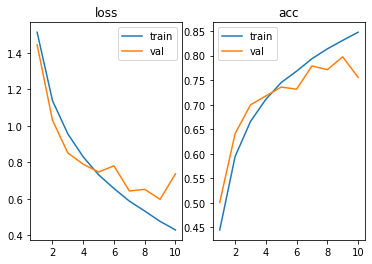

In [ ]:
draw_graphs(y_loss, y_acc, y_loss.keys())

Accuracy of the network on the 10000 test images: 82 %



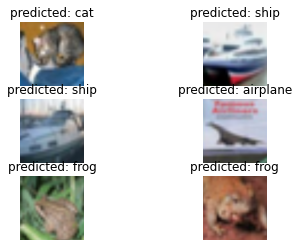

In [ ]:
visualize_acc_preds(model_1, dataloaders['test'])

In [ ]:
model_2 = AlexNet(2048, len(dataloaders['test'].dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_2.parameters(), lr=0.001, momentum=0.9)

In [ ]:
model_2, y_loss, y_acc = train_model(model_2, criterion, optimizer, dict(itertools.islice(dataloaders.items(), 0, 2)), num_epochs=5)

Epoch 1/5
----------
train Loss: 1.5845 Acc: 0.4116
val Loss: 1.4379 Acc: 0.4965
Epoch 2/5
----------
train Loss: 1.1503 Acc: 0.5826
val Loss: 1.0033 Acc: 0.6441
Epoch 3/5
----------
train Loss: 0.9581 Acc: 0.6582
val Loss: 0.8653 Acc: 0.6980
Epoch 4/5
----------
train Loss: 0.8372 Acc: 0.7060
val Loss: 0.8362 Acc: 0.7079
Epoch 5/5
----------
train Loss: 0.7443 Acc: 0.7393
val Loss: 0.7432 Acc: 0.7388


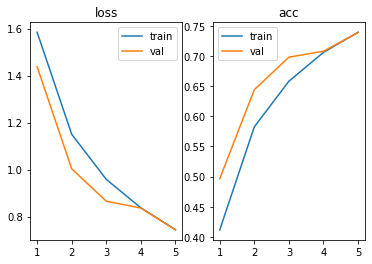

In [ ]:
draw_graphs(y_loss, y_acc, y_loss.keys(), num_epochs=5)

Accuracy of the network on the 10000 test images: 78 %



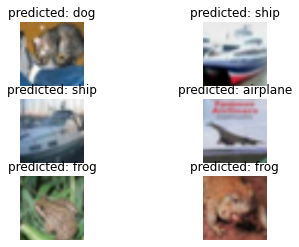

In [ ]:
visualize_acc_preds(model_2, dataloaders['test'])

In [ ]:
model_3 = AlexNet(6144, len(dataloaders['test'].dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_3.parameters(), lr=0.005, momentum=0.9)

In [ ]:
model_3, y_loss, y_acc = train_model(model_3, criterion, optimizer, dict(itertools.islice(dataloaders.items(), 0, 2)), num_epochs=15)

Epoch 1/15
----------
train Loss: 1.4752 Acc: 0.4577
val Loss: 1.3489 Acc: 0.5307
Epoch 2/15
----------
train Loss: 1.0739 Acc: 0.6170
val Loss: 0.9741 Acc: 0.6520
Epoch 3/15
----------
train Loss: 0.8792 Acc: 0.6903
val Loss: 0.7989 Acc: 0.7199
Epoch 4/15
----------
train Loss: 0.7600 Acc: 0.7319
val Loss: 0.7219 Acc: 0.7452
Epoch 5/15
----------
train Loss: 0.6791 Acc: 0.7621
val Loss: 0.6990 Acc: 0.7534
Epoch 6/15
----------
train Loss: 0.6061 Acc: 0.7884
val Loss: 0.6600 Acc: 0.7715
Epoch 7/15
----------
train Loss: 0.5460 Acc: 0.8079
val Loss: 0.6706 Acc: 0.7684
Epoch 8/15
----------
train Loss: 0.4914 Acc: 0.8282
val Loss: 0.5765 Acc: 0.7992
Epoch 9/15
----------
train Loss: 0.4432 Acc: 0.8447
val Loss: 0.5994 Acc: 0.7905
Epoch 10/15
----------
train Loss: 0.4014 Acc: 0.8580
val Loss: 0.6032 Acc: 0.7952
Epoch 11/15
----------
train Loss: 0.3663 Acc: 0.8694
val Loss: 0.7002 Acc: 0.7735
Epoch 12/15
----------
train Loss: 0.3387 Acc: 0.8806
val Loss: 0.5803 Acc: 0.8085
Epoch 13/15
-

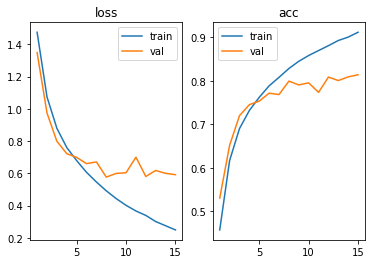

In [ ]:
draw_graphs(y_loss, y_acc, y_loss.keys(), num_epochs=15)

Accuracy of the network on the 10000 test images: 78 %



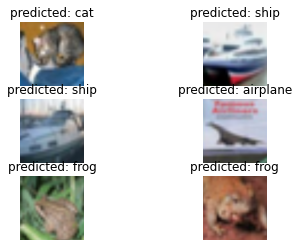

In [ ]:
visualize_acc_preds(model_3, dataloaders['test'])